# Machine Learning and AI

Once the data is preprocessed, we are going to train Machine Learning models in order to predict some attributes using the rest as predictor variables.

First, we have to take into account the following considerations:

1. The data has been preprocessed in the notebook "Preprocessing.ipynb", as well as in the end of "visualizationsEDA.ipynb" (after visualizations). Any changes to the preprocessing should be done there.
2. We will use cross validation to evaluate our models.

# TODO

- Smogon Tiers
- Graph analysis
- Clustering
- Type from Pokémon Image (Computer Vision)

In [128]:
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef, confusion_matrix, make_scorer, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.cm as cm


from os import listdir
from os.path import isfile, join


import tensorflow as tf
import keras
import keras.utils as np_utils
from tensorflow.keras.utils import load_img

from keras.preprocessing.image import img_to_array

#from autogluon.tabular import TabularPredictor

import unicodedata

import random

SEED = 777
PATH_IMGS = '../Images/Icons'

random.seed(SEED)
np.random.seed(SEED)


# Data reading and auxiliary functions

In [86]:
data = pd.read_csv("../data/PokemonPreprocML.csv", index_col=None)
data.index = data.Name
data = data.drop(['Name'], axis=1)
data

DexNumber             Category          Ability1  \
Name                                                                        
Victini                        494      Victory Pokémon      Victory Star   
Bulbasaur                        1         Seed Pokémon          Overgrow   
Ivysaur                          2         Seed Pokémon          Overgrow   
Venusaur                         3         Seed Pokémon          Overgrow   
Charmander                       4       Lizard Pokémon             Blaze   
...                            ...                  ...               ...   
Iron Boulder                  1022      Paradox Pokémon       Quark Drive   
Iron Crown                    1023      Paradox Pokémon       Quark Drive   
Terapagos Normal Form         1024         Tera Pokémon        Tera Shift   
Terapagos Terastal Form       1024         Tera Pokémon        Tera Shell   
Pecharunt                     1025  Subjugation Pokémon  Poison Puppeteer   

                        Ability2 HiddenAbility  Generation   Hp  Attack  \
Name                                                                      
Victini                     None          None           5  100     100   
Bulbasaur                   None   Chlorophyll           1   45      49   
Ivysaur                     None   Chlorophyll           1   60      62   
Venusaur                    None   Chlorophyll           1   80      82   
Charmander                  None   Solar Power           1   39      52   
...                          ...           ...         ...  ...     ...   
Iron Boulder                None          None           9   90     120   
Iron Crown                  None          None           9   90      72   
Terapagos Normal Form       None          None           9   90      65   
Terapagos Terastal Form     None          None           9   95      95   
Pecharunt                   None          None           9   88      88   

                         Defense  SpecialAttack  ...  Egg_Field  Egg_Flying  \
Name                                             ...                          
Victini                      100            100  ...          0           0   
Bulbasaur                     49             65  ...          0           0   
Ivysaur                       63             80  ...          0           0   
Venusaur                      83            100  ...          0           0   
Charmander                    43             60  ...          0           0   
...                          ...            ...  ...        ...         ...   
Iron Boulder                  80             68  ...          0           0   
Iron Crown                   100            122  ...          0           0   
Terapagos Normal Form         85             65  ...          0           0   
Terapagos Terastal Form      110            105  ...          0           0   
Pecharunt                    160             88  ...          0           0   

                         Egg_Grass  Egg_Human-Like  Egg_Mineral  Egg_Monster  \
Name                                                                           
Victini                          0               0            0            0   
Bulbasaur                        1               0            0            1   
Ivysaur                          1               0            0            1   
Venusaur                         1               0            0            1   
Charmander                       0               0            0            1   
...                            ...             ...          ...          ...   
Iron Boulder                     0               0            0            0   
Iron Crown                       0               0            0            0   
Terapagos Normal Form            0               0            0            0   
Terapagos Terastal Form          0               0            0            0   
Pecharunt                        0               0         

In [87]:
data.columns

Index(['DexNumber', 'Category', 'Ability1', 'Ability2', 'HiddenAbility',
       'Generation', 'Hp', 'Attack', 'Defense', 'SpecialAttack',
       'SpecialDefense', 'Speed', 'TotalStats', 'Weight', 'Height',
       'GenderProbM', 'NoGender', 'CatchRate', 'EggCycles', 'LevelingRate',
       'BaseFriendship', 'IsLegendary', 'IsMythical', 'IsUltraBeast',
       'HasMega', 'EvoStage', 'TotalEvoStages', 'PreevoName', 'Type_Bug',
       'Type_Dark', 'Type_Dragon', 'Type_Electric', 'Type_Fairy',
       'Type_Fighting', 'Type_Fire', 'Type_Flying', 'Type_Ghost', 'Type_Grass',
       'Type_Ground', 'Type_Ice', 'Type_Normal', 'Type_Poison', 'Type_Psychic',
       'Type_Rock', 'Type_Steel', 'Type_Water', 'DamageFromNormal',
       'DamageFromFighting', 'DamageFromFlying', 'DamageFromPoison',
       'DamageFromGround', 'DamageFromRock', 'DamageFromBug',
       'DamageFromGhost', 'DamageFromSteel', 'DamageFromFire',
       'DamageFromWater', 'DamageFromGrass', 'DamageFromElectric',
       'DamageFromP

Auxiliary functions

In [88]:
def transformpath(path):
    if path == f'{PATH_IMGS}/Type: Null.png':
        path = f'{PATH_IMGS}/Type Null.png'
    elif path == f'{PATH_IMGS}/Silvally Type: Normal.png':
        path = f'{PATH_IMGS}/Silvally.png'  
    return unicodedata.normalize('NFC', path)

# Prediction of binary attributes (IsLegendary, IsMythic, HasMega, IsUltraBeast, NoGender)

### Data preparation and considerations

In [105]:
x = data.copy()
x = x.drop(['DexNumber', 'Category', 'Ability1', 'Ability2', 'HiddenAbility', 'Generation', 'IsLegendary', 'IsMythical', 'IsUltraBeast', 'PreevoName'], axis=1)
y = data['IsLegendary']
print(f"No Legendary: {(y == 0).sum()}, ({(100*(y == 0).sum() / y.shape)[0]}%)")
print(f"Legendary: {(y == 1).sum()}, ({(100*(y == 1).sum() / y.shape)[0]}%)")


No Legendary: 1082, (91.77268871925361%)
Legendary: 97, (8.227311280746395%)


We can see that the data is highly unbalanced, so Accuracy is not a good evaluation metric. As the dataset size is small, there is no point in using undersampling methods. Upsampling in the other hand could be benefitial in order to increase the dataset size, but it can generate lots of repeated Pokémon which could bias the results, or create lots of artificial Pokémon, which could not be as precise. Let's try only using metrics which are prepared for these kind of situations.

We will use two different metrics to test the results obtained:

- Matthews Correlation Coefficient (MCC), which is a good metric for these cases of unbalance. $$ MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}} $$ This metric ranges from -1 (totally incorrect classification) to 1 (perfect prediction), being a value of 0 a prediction no better than random prediction.

- Area under Precision-Recall Curve (PR-AUC), considers both precision and recall, being these: $$\text{Precision =} \frac{TP}{TP+FP},\ \text{Recall =} \frac{TP}{TP+FN} $$ Precision and recall are usually inversely related (not always necesarily. Recall is monotonically increasing with an increasing classification threshold, but precision not always decreases), and we will study the area under the curve of both metrics varying the classification threshold.

Finally, we will divide the data in 90% training and 10% test

In [106]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=SEED)

### Models to use cross validation

We will train our moders considering Mathews Correlation Coefficient, and then calculate the PR-AUC

In [107]:
models_dict = {
    'LightGBM': lgb.LGBMClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier()
}

mcc_scorer = make_scorer(matthews_corrcoef)

results_cv_dict = {model: [] for model in models_dict}

for model in models_dict:
    print(model)
    clf = models_dict[model]
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring=mcc_scorer)
    print('- Cross Validation Scores: ', scores)
    print('- Mean Cross Validation Score: ', np.mean(scores))
    results_cv_dict[model] = np.mean(scores)
    print('- Standard Deviation of Cross Validation Scores: ', np.std(scores))

LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 78, number of negative: 876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 954, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081761 -> initscore=-2.418657
[LightGBM] [Info] Start training from score -2.418657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [108]:
print('Ranking of models:')
metric = 'MCC'
i = 1
for key, elem in dict(sorted(results_cv_dict.items(), key=lambda item: item[1], reverse=True)).items():
    print(f"{i}: {key} ({elem} {metric})")
    i = i + 1

Ranking of models:
1: LightGBM (0.9136974519670783 MCC)
2: GradientBoostingClassifier (0.9130328310224302 MCC)
3: DecisionTreeClassifier (0.8726031979906139 MCC)
4: AdaBoostClassifier (0.8689406139718148 MCC)
5: RandomForestClassifier (0.8539018765259921 MCC)


### Building an ensemble model

After having calculated the cross validation scores for each machine learning model, let us train an ensemble model, and combine the results of all models.

Let's start predicting for each model:

In [109]:
predictions_dict = {}
for model in models_dict:
    clf = models_dict[model]
    clf.fit(x_train, y_train)
    predictions_dict[model] = clf.predict_proba(x_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 87, number of negative: 974
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 1061, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081998 -> initscore=-2.415503
[LightGBM] [Info] Start training from score -2.415503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Now, let's combine all the predictions performed. To do this, we first need to calculate the weight of each model. We will do it using cross validation scores.

In [110]:
w_min = min(results_cv_dict.values())
w_max = max(results_cv_dict.values())
new_w = {model: (score - w_min) / (w_max - w_min) for model,score in results_cv_dict.items()}
suma = sum(new_w.values())
weights_dict = {model: score / suma for model,score in new_w.items()}

Finally, let us combine all the predictions using weighted average, and transform them into binary labels

Test results:


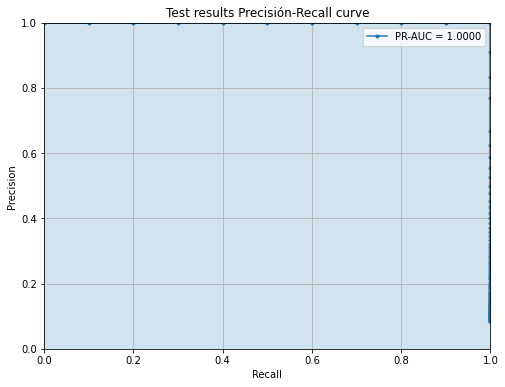

Test PR-AUC: 0.9999999999999999
Test MCC (0.5 threshold): 1.0


In [111]:
predictions = np.zeros(len(x_test))
for model in models_dict:
    predictions += weights_dict[model] * predictions_dict[model][:,1]

#print(predictions)
precision, recall, thres = precision_recall_curve(y_test, predictions)
pr_auc = auc(recall, precision)  # Área bajo la curva PR

print("Test results:")

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'PR-AUC = {pr_auc:.4f}')
plt.fill_between(recall,precision,alpha =0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Test results Precisión-Recall curve')
plt.legend()
plt.grid()
plt.show()

predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

print(f"Test PR-AUC: {auc(recall, precision)}")
print(f"Test MCC (0.5 threshold): {matthews_corrcoef(y_test, predictions)}")

In this case the prediction was perfect. Nonetheless, we will repeat this process using different seeds for partitions to test its robustness

### Repeat for multiple seeds

In [112]:
NUM_SEEDS = 20

mccs = []
pr_aucs = []
precisions = []
recalls = []

for seed in range(SEED, SEED + NUM_SEEDS):
    # Data partition
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=seed) 

    # Models definition
    results_cv_dict = {model: [] for model in models_dict}  

    # Models training
    for model in models_dict:                       
        clf = models_dict[model]
        cv = StratifiedKFold(n_splits=10)
        scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring=mcc_scorer)
        results_cv_dict[model] = np.mean(scores)

    # Obtention of test results using those models
    predictions_dict = {}
    for model in models_dict:
        clf = models_dict[model]
        clf.fit(x_train, y_train)
        predictions_dict[model] = clf.predict_proba(x_test)

    # Weights for ensemble model
    w_min = min(results_cv_dict.values())
    w_max = max(results_cv_dict.values())
    new_w = {model: (score - w_min) / (w_max - w_min) for model,score in results_cv_dict.items()}
    suma = sum(new_w.values())
    weights_dict = {model: score / suma for model,score in new_w.items()}
    
    # Make final predictions
    predictions = np.zeros(len(x_test))
    for model in models_dict:
        predictions += weights_dict[model] * predictions_dict[model][:,1]

    #Calculate PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, predictions)
    precisions.append(precision)
    recalls.append(recall)
    pr_aucs.append(auc(recall, precision))

    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0

    # Calculate Matthews-corrcoef
    mccs.append((matthews_corrcoef(y_test, predictions)))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 78, number of negative: 876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 954, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081761 -> initscore=-2.418657
[LightGBM] [Info] Start training from score -2.418657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Final test results using different partition seeds:
--- MCC ---
Mean value: 0.9675915459244857
Std: 0.05318338613578512
Values: [1.0, 0.9490381450044043, 1.0, 0.8907407407407407, 1.0, 1.0, 1.0, 1.0, 0.9490381450044043, 1.0, 1.0, 1.0, 1.0, 0.8443778635927036, 1.0, 0.9443215126566032, 0.8252763664864523, 1.0, 1.0, 0.9490381450044043]
--- PR-AUC ---
Mean value: 0.9813926837051836
Std: 0.05536021735653283
Values: [0.9999999999999999, 0.9904545454545454, 0.9999999999999999, 0.9720202020202021, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9904545454545454, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9223666611166611, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.75255772005772]


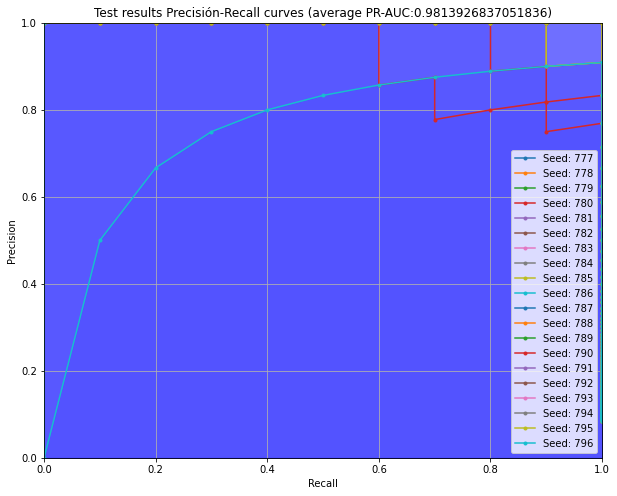

In [ ]:
print("Final test results for Legendary classification using different partition seeds:")
print("--- MCC ---")
print(f"Mean value: {np.array(mccs).mean()}")
print(f"Std: {np.array(mccs).std()}")
print(f"Values: {mccs}")
print("--- PR-AUC ---")
print(f"Mean value: {np.array(pr_aucs).mean()}")
print(f"Std: {np.array(pr_aucs).std()}")
print(f"Values: {pr_aucs}")

plt.figure(figsize=(10,8))

for i in range(NUM_SEEDS):
    plt.plot(recalls[i], precisions[i], marker='.', label=f'Seed: {SEED + i}')
    plt.fill_between(recalls[i], precisions[i], alpha=float(1.0/NUM_SEEDS), color='blue')
    

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title(f'Test results Precisión-Recall curves (average PR-AUC:{np.array(pr_aucs).mean()})')
plt.legend()
plt.grid()
plt.show()

So we can conclude that being legendary can be predicted very precisely. Let us try to predict the other 2 attributes using the same technique, as they are even more unbalanced:

In [114]:
x = data.copy()
x = x.drop(['DexNumber', 'Category', 'Ability1', 'Ability2', 'HiddenAbility', 'Generation', 'IsLegendary', 'IsMythical', 'IsUltraBeast', 'PreevoName'], axis=1)
y = data['IsMythical']
print(f"No Mythical: {(y == 0).sum()}, ({(100*(y == 0).sum() / y.shape)[0]}%)")
print(f"Mythical: {(y == 1).sum()}, ({(100*(y == 1).sum() / y.shape)[0]}%)")

NUM_SEEDS = 20

mccs = []
pr_aucs = []
precisions = []
recalls = []

for seed in range(SEED, SEED + NUM_SEEDS):
    # Data partition
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=seed) 

    # Models definition
    results_cv_dict = {model: [] for model in models_dict}  

    # Models training
    for model in models_dict:                       
        clf = models_dict[model]
        cv = StratifiedKFold(n_splits=10)
        scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring=mcc_scorer)
        results_cv_dict[model] = np.mean(scores)

    # Obtention of test results using those models
    predictions_dict = {}
    for model in models_dict:
        clf = models_dict[model]
        clf.fit(x_train, y_train)
        predictions_dict[model] = clf.predict_proba(x_test)

    # Weights for ensemble model
    w_min = min(results_cv_dict.values())
    w_max = max(results_cv_dict.values())
    new_w = {model: (score - w_min) / (w_max - w_min) for model,score in results_cv_dict.items()}
    suma = sum(new_w.values())
    weights_dict = {model: score / suma for model,score in new_w.items()}
    
    # Make final predictions
    predictions = np.zeros(len(x_test))
    for model in models_dict:
        predictions += weights_dict[model] * predictions_dict[model][:,1]

    #Calculate PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, predictions)
    precisions.append(precision)
    recalls.append(recall)
    pr_aucs.append(auc(recall, precision))

    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0

    # Calculate Matthews-corrcoef
    mccs.append((matthews_corrcoef(y_test, predictions)))

No Mythical: 1145, (97.11620016963528%)
Mythical: 34, (2.883799830364716%)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27, number of negative: 927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 954, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028302 -> initscore=-3.536117
[LightGBM] [Info] Start training from score -3.536117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Final test results for Mythical classification using different partition seeds:
--- MCC ---
Mean value: 0.9047538328775232
Std: 0.14039603189017621
Values: [1.0, 0.6579710144927536, 0.6579710144927536, 1.0, 1.0, 0.8129695813681377, 1.0, 1.0, 1.0, 0.8129695813681377, 0.8129695813681377, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5723943812052383, 1.0, 1.0, 0.7678315032553069]
--- PR-AUC ---
Mean value: 0.9576633986928105
Std: 0.09151322672814444
Values: [1.0, 0.7169117647058822, 0.7169117647058822, 1.0, 1.0, 0.9027777777777777, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8166666666666667, 1.0, 1.0, 1.0]


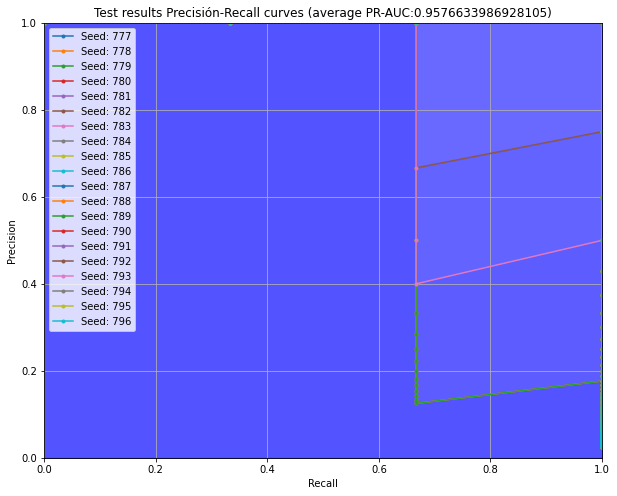

In [115]:
print("Final test results for Mythical classification using different partition seeds:")
print("--- MCC ---")
print(f"Mean value: {np.array(mccs).mean()}")
print(f"Std: {np.array(mccs).std()}")
print(f"Values: {mccs}")
print("--- PR-AUC ---")
print(f"Mean value: {np.array(pr_aucs).mean()}")
print(f"Std: {np.array(pr_aucs).std()}")
print(f"Values: {pr_aucs}")

plt.figure(figsize=(10,8))

for i in range(NUM_SEEDS):
    plt.plot(recalls[i], precisions[i], marker='.', label=f'Seed: {SEED + i}')
    plt.fill_between(recalls[i], precisions[i], alpha=float(1.0/NUM_SEEDS), color='blue')
    

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title(f'Test results Precisión-Recall curves (average PR-AUC:{np.array(pr_aucs).mean()})')
plt.legend()
plt.grid()
plt.show()

In [116]:
x = data.copy()
x = x.drop(['DexNumber', 'Category', 'Ability1', 'Ability2', 'HiddenAbility', 'Generation', 'IsLegendary', 'IsMythical', 'IsUltraBeast', 'PreevoName'], axis=1)
y = data['IsUltraBeast']
print(f"No Ultra Beast: {(y == 0).sum()}, ({(100*(y == 0).sum() / y.shape)[0]}%)")
print(f"Ultra Beast: {(y == 1).sum()}, ({(100*(y == 1).sum() / y.shape)[0]}%)")

NUM_SEEDS = 20

mccs = []
pr_aucs = []
precisions = []
recalls = []

for seed in range(SEED, SEED + NUM_SEEDS):
    # Data partition
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=seed) 

    # Models definition
    results_cv_dict = {model: [] for model in models_dict}  

    # Models training
    for model in models_dict:                       
        clf = models_dict[model]
        cv = StratifiedKFold(n_splits=10)
        scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring=mcc_scorer)
        results_cv_dict[model] = np.mean(scores)

    # Obtention of test results using those models
    predictions_dict = {}
    for model in models_dict:
        clf = models_dict[model]
        clf.fit(x_train, y_train)
        predictions_dict[model] = clf.predict_proba(x_test)

    # Weights for ensemble model
    w_min = min(results_cv_dict.values())
    w_max = max(results_cv_dict.values())
    new_w = {model: (score - w_min) / (w_max - w_min) for model,score in results_cv_dict.items()}
    suma = sum(new_w.values())
    weights_dict = {model: score / suma for model,score in new_w.items()}
    
    # Make final predictions
    predictions = np.zeros(len(x_test))
    for model in models_dict:
        predictions += weights_dict[model] * predictions_dict[model][:,1]

    #Calculate PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, predictions)
    precisions.append(precision)
    recalls.append(recall)
    pr_aucs.append(auc(recall, precision))

    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0

    # Calculate Matthews-corrcoef
    mccs.append((matthews_corrcoef(y_test, predictions)))

No Ultra Beast: 1168, (99.06700593723494%)
Ultra Beast: 11, (0.9329940627650551%)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9, number of negative: 945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 954, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009434 -> initscore=-4.653960
[LightGBM] [Info] Start training from score -4.653960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Final test results for UltraBeast classification using different partition seeds:
--- MCC ---
Mean value: 1.0
Std: 0.0
Values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
--- PR-AUC ---
Mean value: 1.0
Std: 0.0
Values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


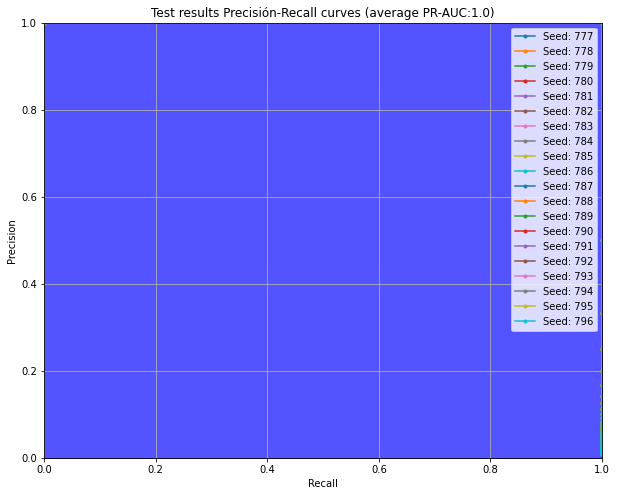

In [117]:
print("Final test results for UltraBeast classification using different partition seeds:")
print("--- MCC ---")
print(f"Mean value: {np.array(mccs).mean()}")
print(f"Std: {np.array(mccs).std()}")
print(f"Values: {mccs}")
print("--- PR-AUC ---")
print(f"Mean value: {np.array(pr_aucs).mean()}")
print(f"Std: {np.array(pr_aucs).std()}")
print(f"Values: {pr_aucs}")

plt.figure(figsize=(10,8))

for i in range(NUM_SEEDS):
    plt.plot(recalls[i], precisions[i], marker='.', label=f'Seed: {SEED + i}')
    plt.fill_between(recalls[i], precisions[i], alpha=float(1.0/NUM_SEEDS), color='blue')
    

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title(f'Test results Precisión-Recall curves (average PR-AUC:{np.array(pr_aucs).mean()})')
plt.legend()
plt.grid()
plt.show()

# LevelingRate as ordinal classification

In [ ]:
# 3. Convert ordinal labels to numerical values
encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
df['Target'] = encoder.fit_transform(df[['Target']])

# 4. Split the data into training and test sets
X = df.drop('Target', axis=1)  # Features
y = df['Target']  # Target variable (ordinal)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Non-supervised learning: Clustering

# Computer Vision: Predicting types using minisprites

### Read Images

We first read all images from the icons folder

In [129]:
imgs = []
img_names = []

for name in listdir(PATH_IMGS):
    if isfile(join(PATH_IMGS, name)) and f"{PATH_IMGS}/{name}"[-4:] == '.png':
        imgs.append(img_to_array(load_img(transformpath(f"{PATH_IMGS}/{name}"), color_mode='rgba', target_size = (64, 64), interpolation="bilinear")))
        if transformpath(f"{PATH_IMGS}/{name}").split('/')[-1][:-4] == 'Type Null':
            img_names.append('Type: Null')
        elif transformpath(f"{PATH_IMGS}/{name}").split('/')[-1][:-4] == 'Silvally':
            img_names.append('Silvally Type: Normal')
        else:
            img_names.append(transformpath(f"{PATH_IMGS}/{name}").split('/')[-1][:-4])

print(img_names)
print(len(imgs), "images have been read.")

['Vivillon_19', 'Parasect', 'Sobble', 'Lumineon', 'Raikou', 'Runerigus', 'Dedenne', 'Pyroar', 'Pawmi', 'Articuno', 'Maushold Family Of Four', 'Magmortar', 'Hisuian Decidueye', 'Ogerpon_8', 'Bulbasaur', 'Mimikyu Disguised Form', 'Banette', 'Staraptor', 'Pidove', 'Morgrem', 'Comfey', 'Taillow', 'Charizard', 'Infernape', 'Minior Red Core', 'Sandshrew', 'Marshadow', 'Alakazam', 'Lickitung', 'Alcremie_5', 'Starmie', 'Alcremie_49', 'Deoxys Normal Forme', 'Alcremie_61', 'Yanmega', 'Yveltal', 'Zigzagoon', 'Petilil', 'Torterra', 'Purugly', 'Pikachu_9', 'Tandemaus', 'Cresselia', 'Regigigas', 'Hisuian Lilligant', 'Palkia', 'Thundurus Incarnate Forme', 'Impidimp', 'Froakie', 'Kilowattrel', 'Arrokuda', 'Munna', 'Bellossom', 'Gabite', 'Pikachu_8', 'Gyarados_1', 'Mareep', 'Shieldon', 'Alcremie_60', 'Sneasler', 'Alcremie_48', 'Alcremie_4', 'Stoutland', 'Corviknight', 'Squawkabilly White Plumage', 'Pidgeot_1', 'Accelgor', 'Makuhita', 'Seviper', 'Tirtouga', 'Squawkabilly Yellow Plumage', 'Lampent', 'Gim

After that we need to only consider images of Pokémon belonging to the dataset, thus they have to be filtered

In [130]:
imgs = [imgs[i] for i in range(len(imgs)) if img_names[i] in list(data.index)]
img_names = [img_names[i] for i in range(len(imgs)) if img_names[i] in list(data.index)]

print(len(imgs), "images have been read.")

1179 images have been read.


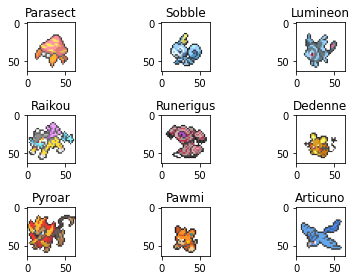

In [ ]:
num = 3
fig, axs = plt.subplots(num, num)
for i in range(0,num**2):
    image = imgs[i].astype(np.uint8)
    axs[int(i/num), i%num].imshow(image)
    axs[int(i/num), i%num].set_title(img_names[i])
fig.tight_layout()
plt.show()
fig.savefig('../Images/Graphics/CVIcons.png', bbox_inches='tight')

### Defining the model

### Apply the modle